## Combining Different Models for Ensemble Learning

### Learning with ensembles:

The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better
generalization performance than each individual classifier alone.

we will focus on the most popular ensemble methods that use the **majority voting principle**.

**Majority voting** simply means that we select the class label that has been predicted by the
majority of classifiers.
“majority vote” refers to binary class settings only.
*However*, it is easy to generalize the majority voting
principle to multiclass settings, which is known as **plurality voting.**

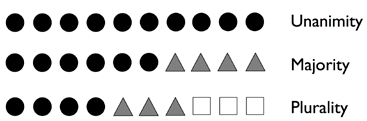

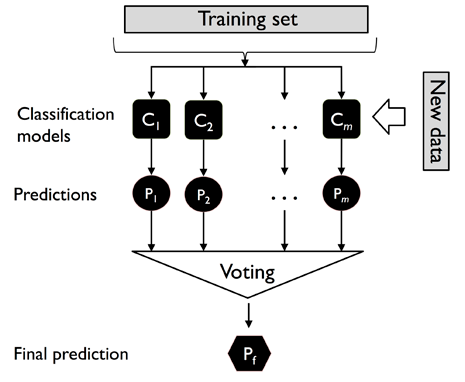

To predict a class label via simple majority or plurality voting, we can combine the predicted class
labels of each individual classifier, Cj, and select the class label, 𝑦^, that received the most votes:

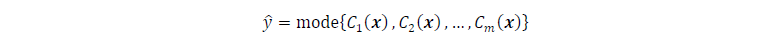

(In statistics, the mode is the most frequent event or result in a set. For example, mode{1, 2, 1, 1, 2,
4, 5, 4} = 1.)

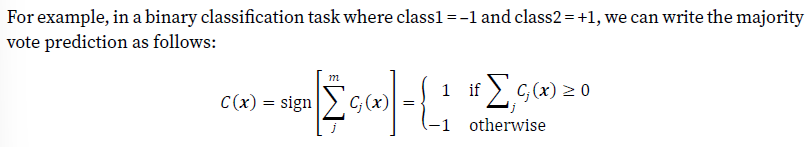

**When does the ensemble make a mistake?**

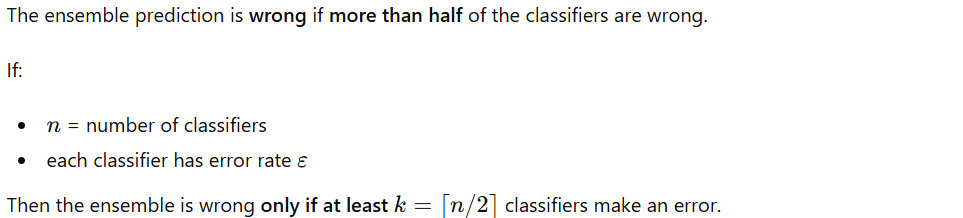

**Even number of classifiers (important note)**

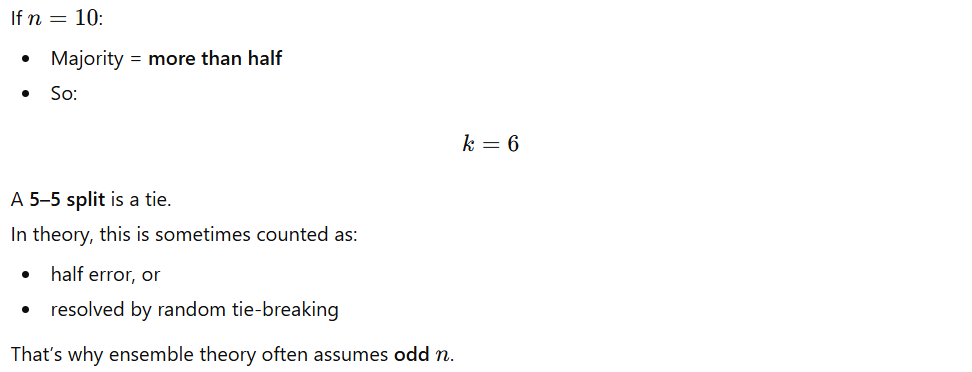

**Why do we use the binomial distribution?**

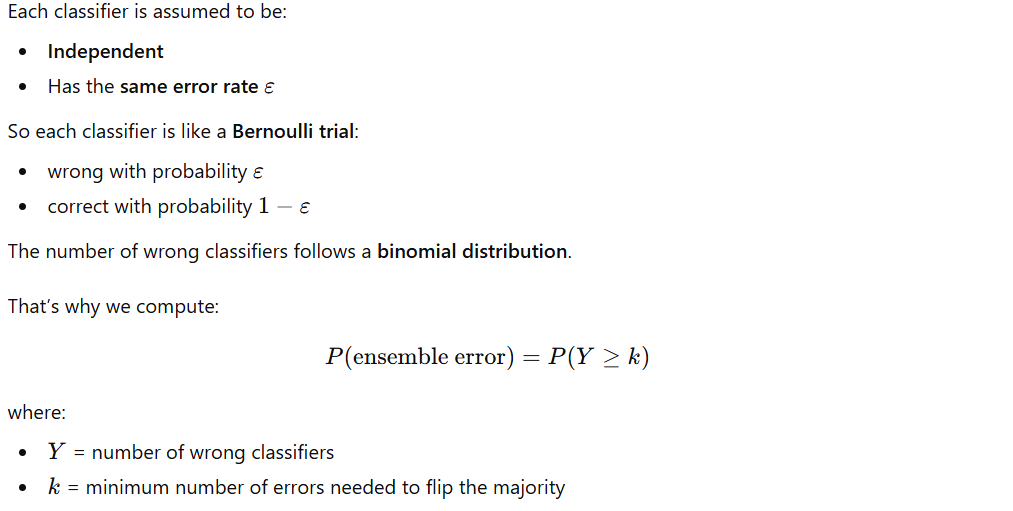

**Understanding the formula**

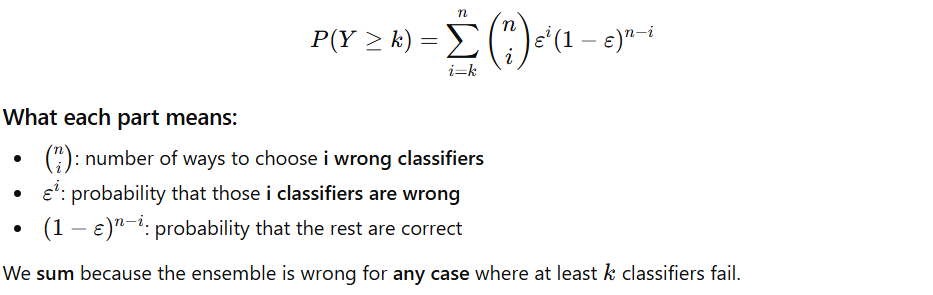

**Concrete example: 11 classifiers**

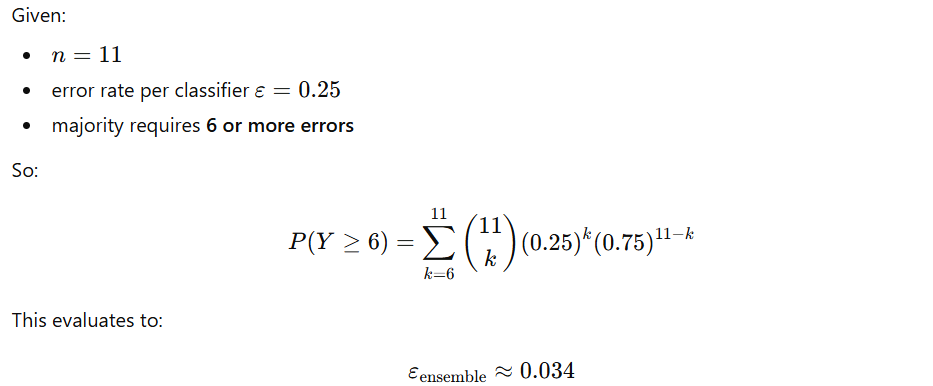

Compare:

Single classifier error: 0.25 (25%)

Ensemble error: 0.034 (3.4%)

**The big intuition (very important)**

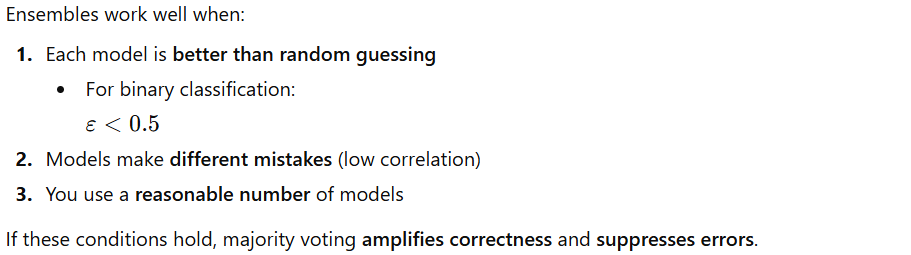

**This analysis assumes:**
Independence

Equal error rates

Binary classes

Odd number of classifiers

**In real life, classifiers are often correlated → improvement is smaller, but still usually real.**

This is why methods like:

Random Forests (random features + data)

Bagging

Boosting (AdaBoost, Gradient Boosting)

try to reduce correlation between models.

In [1]:
import sys
sys.path.insert(0, '..')

In [ ]:
from scipy.special import comb #comb(n, k) → computes the binomial coefficient
import math


def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [3]:
ensemble_error(n_classifier=11, error=0.25)

np.float64(0.03432750701904297)

In [4]:
import numpy as np


error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

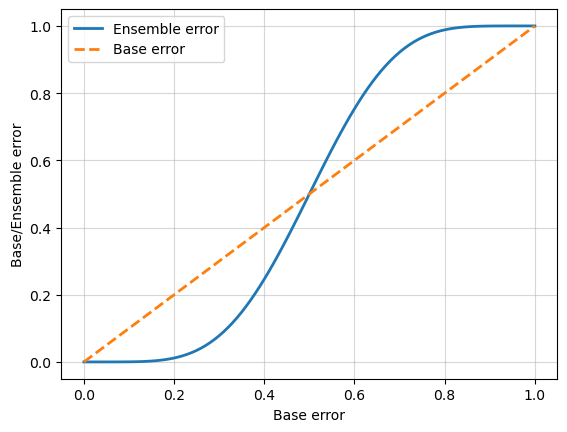

In [5]:
import matplotlib.pyplot as plt


plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('figures/07_03.png', dpi=300)
plt.show()

## implement a simple ensemble classifier for majority voting in Python

Our goal is to build a stronger
meta-classifier that balances out the individual classifiers’ weaknesses on a particular dataset.

we can write the weighted majority vote as follows:

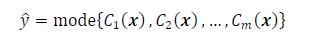

equal weights

-------------------------------------------------------

**Why do we need weights?**

Not all classifiers are equally good.

Examples:

One model is trained on more data

One model performs better on validation

One model specializes in rare cases

So we want:

More reliable classifiers to have more influence

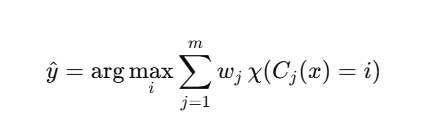

class 0 : 0.2 + 0.2 = 0.4 

class 1 : 0.6 

class 1 > class 0 


In [7]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

np.int64(1)

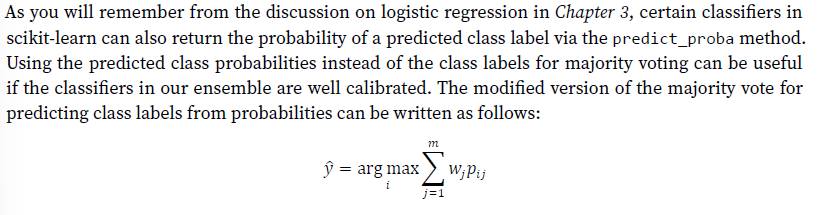

In [8]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [9]:
np.argmax(p)

np.int64(0)

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator



import sklearn
base_classes = (ClassifierMixin, BaseEstimator) if sklearn.__version__ >= "0.16" else (BaseEstimator, ClassifierMixin)

# class MajorityVoteClassifier(BaseEstimator, 
#                             ClassifierMixin):

class MajorityVoteClassifier(*base_classes):

    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)} #Needed for GridSearch
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T #shape = [n_examples, n_classifiers]

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out